# Importing necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import torch
import math
import random
import time
import torch.nn.functional as F
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, log_loss, roc_curve, auc, precision_recall_curve, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from cvxopt import matrix, solvers
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import seaborn as sns





# Part 0.0: Data Classes

In [ ]:
class X_values:
    def __init__(self, dataset):
        self.feature_dim = dataset.shape[1]
        self.data_size = dataset.shape[0]
        self.tensor_form = torch.tensor(dataset, dtype=torch.float32)
        #print(f"X_values dim: {self.tensor_form.shape}, feature_dim: {self.feature_dim}, data_size: {self.data_size}")

class Y_values:
    def __init__(self, targets):
        self.data_size = targets.shape[0]
        self.tensor_form = torch.tensor(targets, dtype=torch.float32)
        #print(f"Y_values dim: {self.tensor_form.shape}")


class Dataset:
    def __init__(self, x_values, y_values):
        self.x_tensor = x_values.tensor_form
        self.y_tensor = y_values.tensor_form

        if self.x_tensor.shape[0] != self.y_tensor.shape[0]:
            raise ValueError("Dimensions not equal")

        self.feature_dim = x_values.feature_dim
        self.data_size = x_values.data_size

        #print(f" X: {self.x_tensor.shape}, Y: {self.y_tensor.shape}")

# Part 0.1: Data Class Methods

In [ ]:
def split_dataset(dataset, train_rate, val_rate, test_rate):
    # Set seed
    seed = 462
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    if abs(train_rate + val_rate + test_rate - 1.0) > 1e-6:
        raise ValueError("Split rates not summing up to 1.")

    total_size = dataset.x_tensor.shape[0]
    train_size = int(total_size * train_rate)
    val_size = int(total_size * val_rate)

    indices = torch.randperm(total_size)
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]

    x_train, y_train = dataset.x_tensor[train_indices], dataset.y_tensor[train_indices]
    x_val, y_val = dataset.x_tensor[val_indices], dataset.y_tensor[val_indices]
    x_test, y_test = dataset.x_tensor[test_indices], dataset.y_tensor[test_indices]

    train_dataset = Dataset(X_values(x_train.numpy()), Y_values(y_train.numpy()))
    val_dataset = Dataset(X_values(x_val.numpy()), Y_values(y_val.numpy()))
    test_dataset = Dataset(X_values(x_test.numpy()), Y_values(y_test.numpy()))

    return train_dataset, val_dataset, test_dataset

def read_and_preprocess_csv(file_path):
    data = pd.read_csv(file_path, header=None)
    data = data.apply(pd.to_numeric, errors='coerce').dropna()
    data = data.to_numpy()
    X = data[:, :-1]  # All columns except the last one
    Y = data[:, -1]   # Only the last column

    return X, Y

def five_fold_cross_validation(dataset):
    total_size = dataset.data_size
    indices = torch.randperm(total_size)  # Shuffle dataset indices
    fold_size = total_size // 5
    folds = []

    for i in range(5):
        # Fold indices for corresponding i value
        test_indices = indices[i * fold_size:(i + 1) * fold_size]
        train_indices = torch.cat((indices[:i * fold_size], indices[(i + 1) * fold_size:]))

        # Partitioning the dataset
        x_train, y_train = dataset.x_tensor[train_indices], dataset.y_tensor[train_indices]
        x_test, y_test = dataset.x_tensor[test_indices], dataset.y_tensor[test_indices]

        train_dataset = Dataset(X_values(x_train.numpy()), Y_values(y_train.numpy()))
        test_dataset = Dataset(X_values(x_test.numpy()), Y_values(y_test.numpy()))

        folds.append((train_dataset, test_dataset))

    return folds

# Part 0.2: Plotting Decision Boundary With Features

In [ ]:
# With given model, select two features which has the least amount of
# misclassified data when the data has projected onto these two features.
def plot_decision_boundary_3d_best(test_dataset, sklearn_model, elev, azim):
  best_misclassified_rate = float('inf')
  best_feature_indices = None
  for i in range(test_dataset.feature_dim):
      for j in range(i+1, test_dataset.feature_dim):
        feature_indices = [i, j]
        y_test = test_dataset.y_tensor.numpy()
        y_pred = sklearn_model.predict(test_dataset.x_tensor.numpy())
        misclassified_indices = np.where(y_pred != y_test)[0]
        if len(misclassified_indices) < best_misclassified_rate:
          best_misclassified_rate = len(misclassified_indices)
          best_feature_indices = feature_indices
  feature_indices = best_feature_indices
  x_test_reduced = test_dataset.x_tensor.numpy()[:, feature_indices]
  y_test = test_dataset.y_tensor.numpy()
  y_pred = sklearn_model.predict(test_dataset.x_tensor.numpy())
  misclassified_indices = np.where(y_pred != y_test)[0]
  correct_indices = np.where(y_pred == y_test)[0]

  # Creating a grid for our selected features
  x1_min, x1_max = x_test_reduced[:, 0].min() - 0.5, x_test_reduced[:, 0].max() + 0.5
  x2_min, x2_max = x_test_reduced[:, 1].min() - 0.5, x_test_reduced[:, 1].max() + 0.5
  xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.1), np.arange(x2_min, x2_max, 0.1))
  mesh_input = np.c_[xx1.ravel(), xx2.ravel()]
  Z = sklearn_model.predict_proba(np.concatenate((mesh_input, np.zeros((mesh_input.shape[0],test_dataset.feature_dim-2))),axis=1))[:, 1]
  Z = Z.reshape(xx1.shape)


  # Plotting part
  fig = plt.figure(figsize=(10, 8))
  ax = fig.add_subplot(111, projection='3d')
  ax.plot_surface(xx1, xx2, Z, cmap='viridis', alpha=0.5)
  ax.scatter(x_test_reduced[correct_indices, 0], x_test_reduced[correct_indices, 1], y_test[correct_indices], label='Correctly Classified', color='green', marker='o', s = 20)
  ax.scatter(x_test_reduced[misclassified_indices, 0], x_test_reduced[misclassified_indices, 1], y_test[misclassified_indices], label='Misclassified', color='red', marker='x', s = 20)
  ax.set_xlabel(f'History {feature_indices[0] + 1}')
  ax.set_ylabel(f'History {feature_indices[1] + 1}')
  ax.set_zlabel('Predicted Probability')
  ax.set_title('3D Decision Boundary')
  # Rotating the plot for a better view
  ax.view_init(elev=elev, azim=azim)
  ax.legend()
  plt.show()

# Part 0.3 Plotting Decision Boundary With PCA

In [ ]:
def plot_decision_boundary_3d_pca(sklearn_model, test_dataset, elev, azim):
  y_test = test_dataset.y_tensor.numpy()
  y_pred = sklearn_model.predict(test_dataset.x_tensor.numpy())
  misclassified_indices = np.where(y_pred != y_test)[0]
  correct_indices = np.where(y_pred == y_test)[0]
  # Applying PCA (Principal Component Analysis) for better plotting purposes
  pca = PCA(n_components=2)
  x_test_pca = pca.fit_transform(test_dataset.x_tensor.numpy())

  # Updating 3D Decision Boundary Plotting
  x1_min, x1_max = x_test_pca[:, 0].min() - 0.5, x_test_pca[:, 0].max() + 0.5
  x2_min, x2_max = x_test_pca[:, 1].min() - 0.5, x_test_pca[:, 1].max() + 0.5
  xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.1), np.arange(x2_min, x2_max, 0.1))
  mesh_input = np.c_[xx1.ravel(), xx2.ravel()]
  mesh_input_original = pca.inverse_transform(mesh_input)
  Z = sklearn_model.predict_proba(mesh_input_original)[:, 1]
  Z = Z.reshape(xx1.shape)

  # Plotting part
  fig = plt.figure(figsize=(10, 8))
  ax = fig.add_subplot(111, projection='3d')
  ax.plot_surface(xx1, xx2, Z, cmap='viridis', alpha=0.5)
  ax.scatter(x_test_pca[correct_indices, 0], x_test_pca[correct_indices, 1], y_test[correct_indices], label='Correctly Classified', color='green', marker='o', s=20)
  ax.scatter(x_test_pca[misclassified_indices, 0], x_test_pca[misclassified_indices, 1], y_test[misclassified_indices], label='Misclassified', color='red', marker='x', s=20)
  ax.set_xlabel('Principal Component 1')
  ax.set_ylabel('Principal Component 2')
  ax.set_zlabel('Predicted Probability')
  ax.set_title('3D Decision Boundary (PCA)')
  # Rotating the plot for a better view
  ax.view_init(elev=elev, azim=azim)
  ax.legend()
  plt.show()

# Part 0.4: AUROC Curve

In [ ]:
def plot_auroc(model, test_data):
    y_true = test_data.y_tensor.numpy()
    y_scores = model.predict_proba(test_data.x_tensor.numpy())[:, 1]  # Probability of positive class

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plotting code
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Part 0.5: Confusion Matrix

In [ ]:
def plot_confusion_matrix(model, test_data):
    # Computing the confusion matrix
    y_true = test_data.y_tensor.numpy()
    y_pred = model.predict(test_data.x_tensor.numpy())
    cm = confusion_matrix(y_true, y_pred)
    # !!! REVIEW THIS PART !!!
    if cm.shape[0] == 3:
      modified_cm = np.delete(cm, 0, axis=1)  # Drop first column
      modified_cm = np.delete(modified_cm, 1, axis=0)  # Drop second row
    else:
      modified_cm = cm

    # Plotting codes
    plt.figure(figsize=(8, 6))
    sns.heatmap(modified_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


# Part 0.6: Presicion-Recall Curve

In [ ]:
def plot_precision_recall(model, test_data):
    y_true = test_data.y_tensor.numpy()
    y_scores = model.predict_proba(test_data.x_tensor.numpy())[:, 1]

    # Calculating precision and recall
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)

    # Plotting codes
    plt.figure()
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

# Part 0.7: F1-Score

In [ ]:
def log_f1_score(model, dataset):
    y_true = dataset.y_tensor.numpy()
    y_pred = model.predict(dataset.x_tensor.numpy())
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"F1-Score: {f1}")

# Part 0.8 K-means Classification

(2000, 8)
Converged at iteration 4
Centroids:
 [[ 0.1395122  -0.61560976  0.12       -0.19414634 -0.07317073  0.00878049
  -0.28780488  0.16682927]
 [ 0.9425641   0.94461538  0.95076923  0.9774359   0.9774359   0.9774359
   0.95076923  0.93435897]]
Labels: [0 0 0 ... 1 1 1]


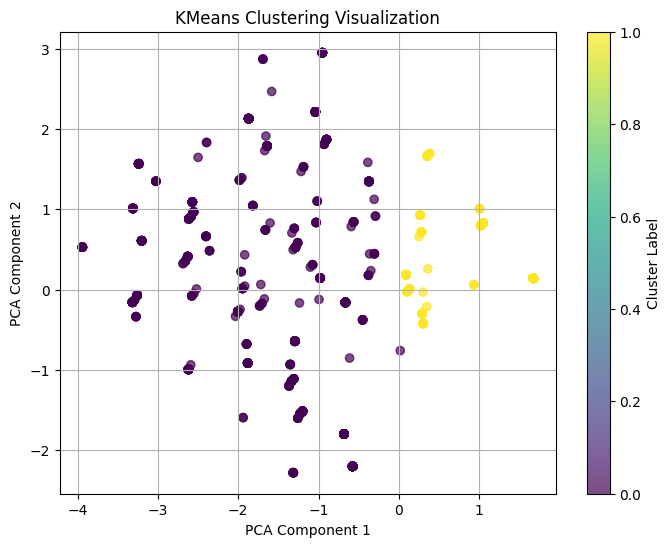

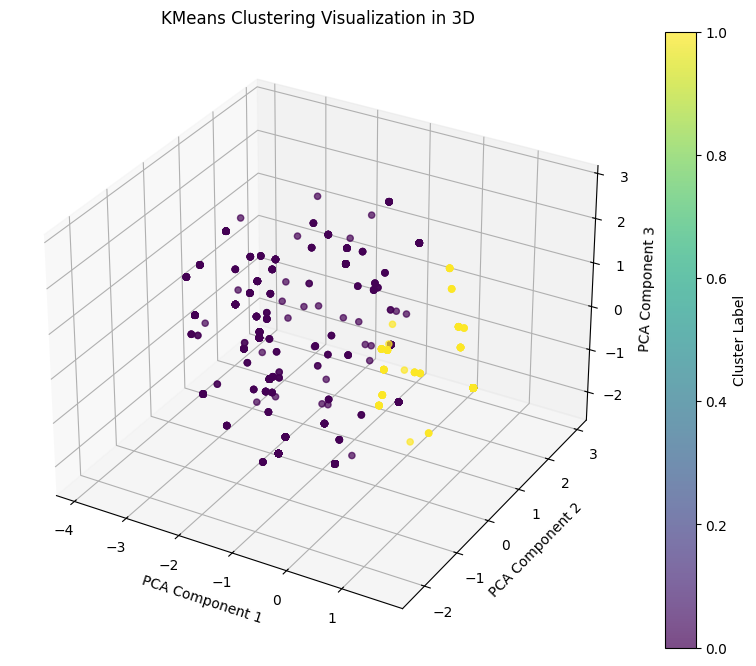

In [ ]:
def kmeans(X, k, max_iters=100, tol=1e-4):
    np.random.seed(13)  # For sake of reproducibility
    n_samples, n_features = X.shape
    centroids = X[np.random.choice(n_samples, k, replace=False)]

    # Applying the algorithm max_iters times
    for iteration in range(max_iters):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])

        if np.linalg.norm(new_centroids - centroids) < tol:
            print(f"Converged at iteration {iteration}")
            break

        centroids = new_centroids

    return centroids, labels

file_path = 'balanced_data_3.csv'
data = pd.read_csv(file_path)

X = data[['feature0', 'feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7']]
X = X.to_numpy()
print(X.shape)

k = 2
centroids, labels = kmeans(X, k)

print("Centroids:\n", centroids)
print("Labels:", labels)

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(X)

# Plotting codes
plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(label='Cluster Label')
plt.title('KMeans Clustering Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.show()

# Reducing our data to 3 featured for 3D visualization
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(X)

# 3D plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    reduced_features[:, 0],
    reduced_features[:, 1],
    reduced_features[:, 2],
    c=labels,
    cmap='viridis',
    alpha=0.7
)

# Add color bar and labels for better visibility
fig.colorbar(scatter, ax=ax, label='Cluster Label')
ax.set_title('KMeans Clustering Visualization in 3D')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.show()

# Part 1.0: Logistic Regression

In [ ]:
# Scratch Implementation
# Stable sigmoid function
def sigmoid(z):
    return torch.where(z >= 0, 1 / (1 + torch.exp(-z)), torch.exp(z) / (1 + torch.exp(z)))

# Cost/Loss function with clipping
def compute_cost(X, y, theta):
    m = y.shape[0]
    h = torch.clip(sigmoid(torch.matmul(X, theta)), 1e-10, 1 - 1e-10)
    cost = -(1 / m) * torch.sum(y * torch.log(h) + (1 - y) * torch.log(1 - h))
    return cost

# Gradient Descent
def gradient_descent(X, y, theta, iter_num, lr):
    m = y.shape[0]
    cost_history = []

    for _ in range(iter_num):
        h = sigmoid(torch.matmul(X, theta))
        gradient = (1 / m) * torch.matmul(X.T, (h - y))
        theta -= lr * gradient
        cost_history.append(compute_cost(X, y, theta).item())  # Append cost for each iteration

    return theta, cost_history

# Logistic Regression Implementation
def logistic_regression(dataset, iter_num=1000, lr=0.01):
    m = dataset.data_size

    # Add bias term (intercept) to X
    X = torch.cat((torch.ones((m, 1)), dataset.x_tensor), dim=1)
    y = dataset.y_tensor.view(-1, 1)  # Ensure y is a column vector
    theta = torch.zeros((X.shape[1], 1), dtype=torch.float32)  # Initialize weights

    # Perform gradient descent
    theta, cost_history = gradient_descent(X, y, theta, iter_num, lr)
    return theta, cost_history


# Scikit Library Implementation
def logistic_regression_sklearn(train_dataset, val_dataset):
    # Initialize the scikit logistic regression model
    model = LogisticRegression(solver='lbfgs', max_iter=1000)

    # Convert tensors to numpy arrays (for scikit compatability)
    x_train = train_dataset.x_tensor.numpy()
    y_train = train_dataset.y_tensor.numpy().ravel()

    x_val = val_dataset.x_tensor.numpy()
    y_val = val_dataset.y_tensor.numpy().ravel()

    # Fit the model
    model.fit(x_train, y_train)

    # Evaluate the model on the validation set using log loss
    val_preds = model.predict_proba(x_val)[:, 1]
    val_loss = log_loss(y_val, val_preds)
    print(f"Validation Log Loss: {val_loss:.4f}")
    print()

    return model

# Testing Functions

# Testing Scikit model
def logistic_regression_test(test_dataset, weights):
    # Adding bias term to test data
    X_test = torch.cat((torch.ones((test_dataset.data_size, 1)), test_dataset.x_tensor), dim=1)
    y_test = test_dataset.y_tensor.view(-1, 1)

    # Logits, probabilities, and predictions
    logits = torch.matmul(X_test, weights)
    probs = 1 / (1 + torch.exp(-logits))
    preds = (probs > 0.5).float()

    # Test loss
    test_loss = compute_cost(X_test, y_test, weights).item()

    # Accuracy calculation
    accuracy = (preds == y_test).float().mean().item()

    print(f"Scratch Model Test Loss: {test_loss:.4f}")
    print(f"Scratch Model Test Accuracy: {accuracy:.4f}")
    return probs, preds

def logistic_regression_test_sklearn(test_dataset, sklearn_model):
    # Obtain and numpyify test data
    x_test = test_dataset.x_tensor.numpy()
    y_test = test_dataset.y_tensor.numpy().ravel()

    # Running model on test dataset
    sklearn_probs = sklearn_model.predict_proba(x_test)[:, 1]

    # Log loss calculation
    sklearn_loss = log_loss(y_test, sklearn_probs)
    print(f"Scikit learn Model Test Log Loss: {sklearn_loss:.4f}")

    # Accuracy
    sklearn_preds = (sklearn_probs > 0.5).astype(np.float32)
    sklearn_accuracy = (sklearn_preds == y_test).mean()
    print(f"Scikit learn Model Test Accuracy: {sklearn_accuracy:.4f}\n")

    return sklearn_loss, sklearn_accuracy



# Part 1.1: Running Logistic Regression

In [ ]:
file_path = 'balanced_data_3.csv'

X, Y = read_and_preprocess_csv(file_path)
Y = (Y + 1) // 2 # Turn y labels into 0 and 1, rather than -1 and 1 (only for LR)
# (in other models, we will not change them as they are already -1 and 1, which is desired)

x_values = X_values(X)
y_values = Y_values(Y)
dataset = Dataset(x_values, y_values)

print("x_values-> ", x_values.tensor_form)
print("y_values-> ", y_values.tensor_form)

# Splitting our whole dataset into train, validation and test datasets
train_dataset, val_dataset, test_dataset = split_dataset(dataset, train_rate=0.7, val_rate=0.15, test_rate=0.15)

# Training Scratch LR
start_time = time.time()
scratch_weights, _ = logistic_regression(train_dataset, iter_num=1000, lr=0.01)
train_runtime = time.time() - start_time
print(f"Scratch LR Training Runtime: {train_runtime:.4f} seconds")

# Testing Scratch LR
start_time = time.time()
logistic_regression_test(test_dataset, scratch_weights)
test_runtime = time.time() - start_time
print(f"Scratch LR Testing Runtime: {test_runtime:.4f} seconds")

# Training Scikit LR
start_time = time.time()
sklearn_model = logistic_regression_sklearn(train_dataset, val_dataset)
train_runtime = time.time() - start_time
print(f"Scikit LR Training Runtime: {train_runtime:.4f} seconds")

# Testing Scikit LR
start_time = time.time()
logistic_regression_test_sklearn(test_dataset, sklearn_model)
test_runtime = time.time() - start_time
print(f"Scikit LR Testing Runtime: {test_runtime:.4f} seconds")


x_values->  tensor([[ 1., -1., -1.,  ..., -1.,  1.,  1.],
        [ 1., -1.,  1.,  ..., -1.,  1.,  1.],
        [ 1., -1.,  1.,  ...,  1., -1.,  1.],
        ...,
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.]])
y_values->  tensor([0., 0., 0.,  ..., 1., 1., 1.])
Scratch Model Test Loss: 0.3240
Scratch Model Test Accuracy: 0.8667
Validation Log Loss: 0.2714

Scikit-learn Model Test Log Loss: 0.2970
Scikit-learn Model Test Accuracy: 0.8933



# Part 1.2: Plot Logistic Regression

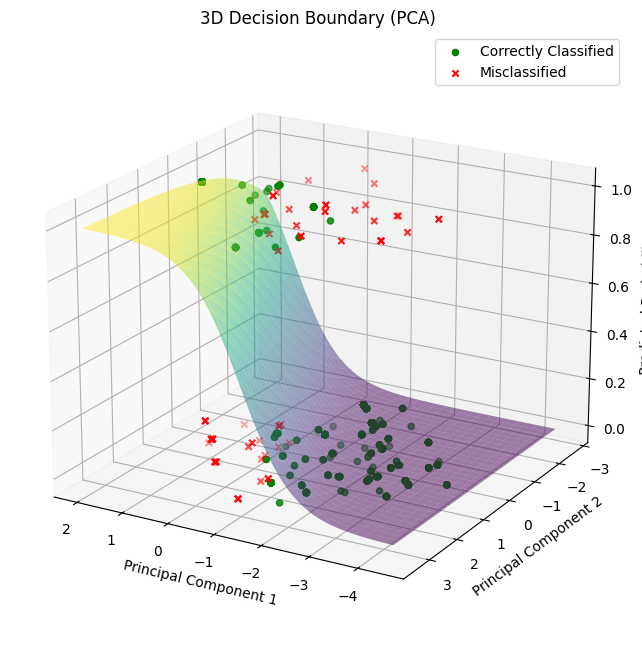

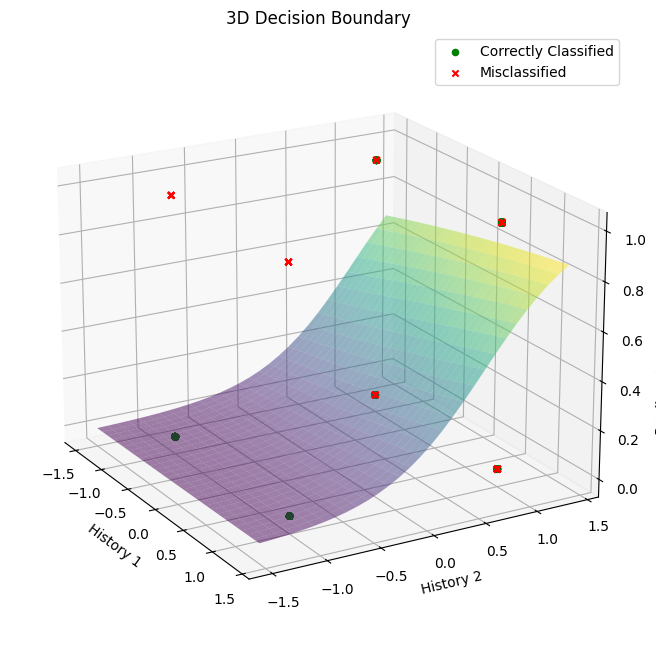

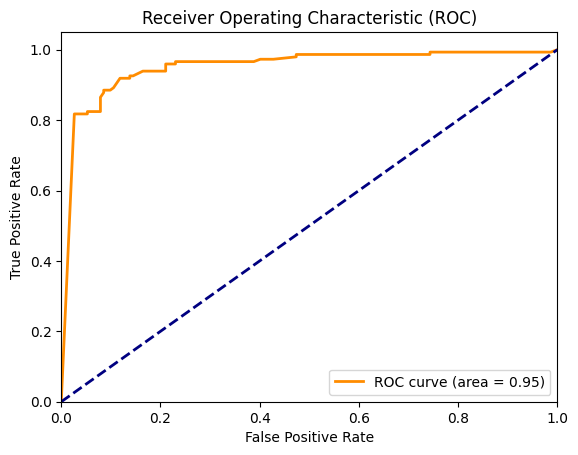

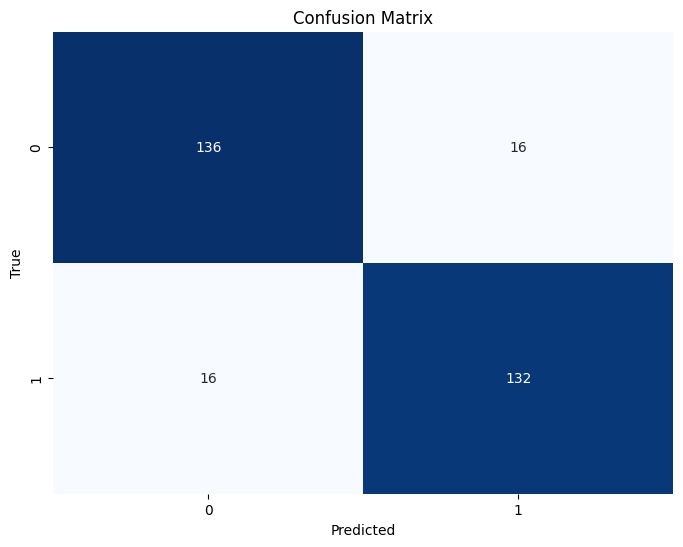

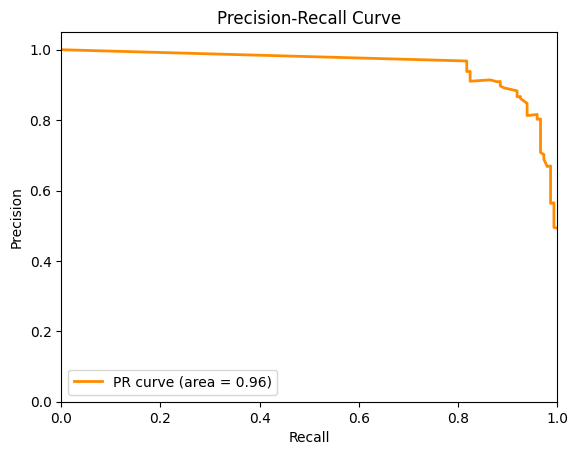

F1-Score: 0.8933333333333333


In [ ]:
plot_decision_boundary_3d_pca(sklearn_model, train_dataset, 20, 120)
plot_decision_boundary_3d_best(train_dataset, sklearn_model, 20, -30)
plot_auroc(sklearn_model, test_dataset)
plot_confusion_matrix(sklearn_model, test_dataset)
plot_precision_recall(sklearn_model, test_dataset)
log_f1_score(sklearn_model, test_dataset)

# [Alternative] 1.0 Logistic Regression

In [ ]:
# Different with above, we have used validation loss during gradient descent, which
# would make our training process easier

# (Codes until the title "Part 2.0: SVM" are included in [Alternative] 1.0
# Logistic Regression, they will be run consecutively)

# Stable sigmoid function
def sigmoid(z):
    return np.where(z >= 0,
                    1 / (1 + np.exp(-z)),
                    np.exp(z) / (1 + np.exp(z)))

# Cost/Loss function with clipping
def compute_cost(X, y, theta):
    m = len(y)
    h = np.clip(sigmoid(np.dot(X, theta)), 1e-10, 1 - 1e-10)
    cost = -(1/m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
    return cost

# Gradient Descent
def gradient_descent(X, y, X_val, y_val, theta, alpha, num_iterations):
    m = len(y)
    cost_history = {
        'train': [],
        'val': []
    }

    patience = 10
    best_val_cost = np.inf
    counter = 0

    for i in range(num_iterations):
        h = sigmoid(np.dot(X, theta))
        gradient = (1/m) * np.dot(X.T, (h - y))
        theta -= alpha * gradient

        train_cost = compute_cost(X, y, theta)
        val_cost = compute_cost(X_val, y_val, theta)

        if val_cost < best_val_cost:
            best_val_cost = val_cost
            counter = 0
        else:
            counter += 1

        if counter >= patience:
            print("Early stopping at iteration: ", i)
            break

        cost_history["train"].append(train_cost)
        cost_history["val"].append(val_cost)

    return theta, cost_history

# Logistic Regression Implementation
def logistic_regression(X, y, alpha=0.01, num_iterations=1000):

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)

    X_train = np.c_[np.ones((len(y_train), 1)), X_train]
    X_val = np.c_[np.ones((len(y_val), 1)), X_val]
    theta = np.zeros(X_train.shape[1])
    theta, cost_history = gradient_descent(X_train, y_train, X_val, y_val, theta, alpha, num_iterations)
    return theta, cost_history

def predict(X, theta):
    X = np.c_[np.ones((len(X), 1)), X]
    return np.round(sigmoid(np.dot(X, theta)))

def predict_proba(X, theta):
    X = np.c_[np.ones((len(X), 1)), X]
    return sigmoid(np.dot(X, theta))


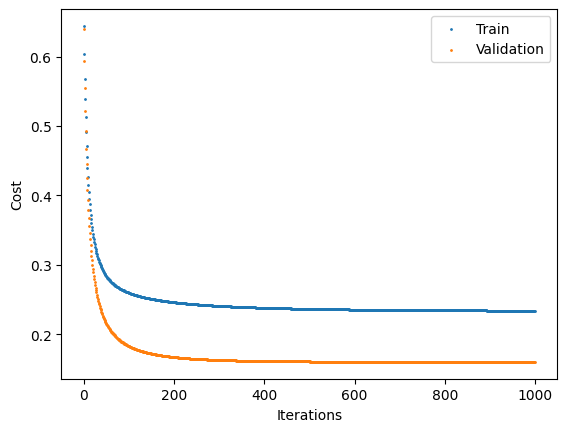

In [ ]:
# Monitor train and validation costs to detect overfitting

data = pd.read_csv('balanced_data_3.csv')
# Extract features and labels
X = data[['feature0', 'feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7']]
y = data['label']
y = (y == 1).astype(int)  # Replace 1 with 1, and -1 with 0

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

theta, cost_history = logistic_regression(X_train, y_train, alpha=0.1, num_iterations=1000)

# Plotting code
plt.scatter(range(len(cost_history['train'])), cost_history['train'], label='Train', s=1)
plt.scatter(range(len(cost_history['val'])), cost_history['val'], label='Validation', s=1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend()
plt.show()



In [ ]:
# Evaluate the model
from sklearn.metrics import accuracy_score

# Training accuracy
predictions = predict(X_train, theta)
accuracy = accuracy_score(y_train, predictions)
cost = compute_cost(np.c_[np.ones((len(y_train), 1)), X_train], y_train, theta)
print(f"Training accuracy: {accuracy}")
print(f"Training cost: {cost}")

print("-" * 50)

# Test accuracy
predictions = predict(X_test, theta)
accuracy = accuracy_score(y_test, predictions)
print(f'Test Accuracy: {accuracy}')
print(f"Test cost: {compute_cost(np.c_[np.ones((len(y_test), 1)), X_test], y_test, theta)}")


Training accuracy: 0.930625
Training cost: 0.21908518989370088
--------------------------------------------------
Test Accuracy: 0.9175
Test cost: 0.2665091408895182


AUROC: 0.9600285064139431


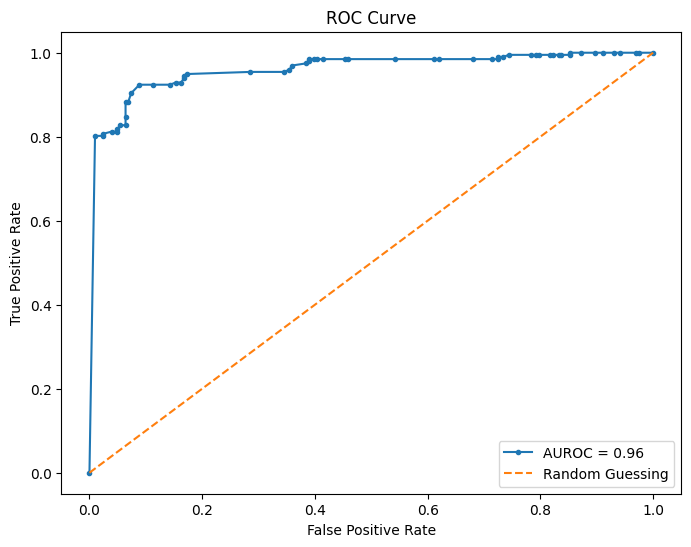

In [ ]:
y_scores = predict_proba(X_test, theta)

# Calculate AUROC
auroc = roc_auc_score(y_test, y_scores)
print(f"AUROC: {auroc}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.', label=f'AUROC = {auroc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [ ]:
# Splitting our dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Custom Logistic Regression
t0 = time.time()
theta, _ = logistic_regression(X_train, y_train, alpha=0.01, num_iterations=1000)
t1 = time.time()
print(f"Training time: {t1 - t0:.8f} seconds")
X_test_with_bias = np.c_[np.ones((X_test.shape[0], 1)), X_test]
custom_predictions = sigmoid(np.dot(X_test_with_bias, theta)) >= 0.5
custom_accuracy = accuracy_score(y_test, custom_predictions)
print(f"Custom Logistic Regression Accuracy: {custom_accuracy * 100:.2f}%")

print("-" * 50)

# Scikit-learn Logistic Regression
t0 = time.time()
sklearn_model = LogisticRegression(max_iter=1000, random_state=42)
t1 = time.time()
print(f"Training time: {t1 - t0:.8f} seconds")
sklearn_model.fit(X_train, y_train)
sklearn_predictions = sklearn_model.predict(X_test)
sklearn_accuracy = accuracy_score(y_test, sklearn_predictions)
print(f"Scikit-learn Logistic Regression Accuracy: {sklearn_accuracy * 100:.2f}%")


Training time: 7.58971143 seconds
Custom Logistic Regression Accuracy: 90.83%
--------------------------------------------------
Training time: 0.00013471 seconds
Scikit-learn Logistic Regression Accuracy: 93.17%


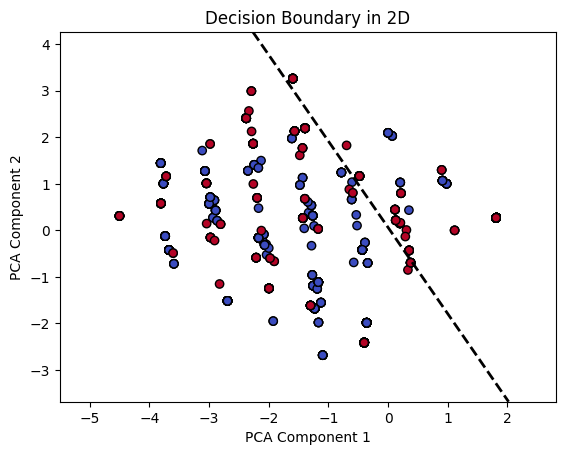

In [ ]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# Create a mesh grid in the 2D reduced space
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

def predict_proba(X, theta):
    X = np.c_[np.ones((len(X), 1)), X]
    return sigmoid(np.dot(X, theta))

# Predict using the original model on the 8D-reconstructed grid points
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_points_8d = pca.inverse_transform(grid_points)
z = predict_proba(grid_points_8d, theta)  # Probability for class 1
z = z.reshape(xx.shape)

# Plot the decision boundary and data
plt.contour(xx, yy, z, levels=[0.5], colors='black', linewidths=2, linestyles='dashed')
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='coolwarm', edgecolors='k')
plt.title('Decision Boundary in 2D')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Part 2.0: SVM

In [ ]:
# Quadaratic program solver code
def svm_dual_qp(X_tensor, y_tensor, C=1):
    # Extracting our data
    X = X_tensor.numpy().astype(np.float64)
    y = y_tensor.numpy().astype(np.float64)
    N = X.shape[0]

    # Kernel matrix
    K = np.dot(X, X.T)

    # Constructing QP parameters
    P = matrix(np.outer(y, y) * K)
    q = matrix(-np.ones(N))
    G = matrix(np.vstack((-np.eye(N), np.eye(N))))
    h = matrix(np.hstack((np.zeros(N), np.ones(N) * C)))
    A = matrix(y.reshape(1, -1))
    b = matrix(0.0)

    # Solveing QP problem
    solvers.options['show_progress'] = False # To stop printing progress information
    solution = solvers.qp(P, q, G, h, A, b)

    # Extracting alpha values
    alphas = np.ravel(solution['x'])
    return torch.tensor(alphas, dtype=torch.float32)

# Scratch SVM
# Train SVM using the dual QP approach
def train_svm_dual_qp(dataset, C=1.0):
    alphas = svm_dual_qp(dataset.x_tensor, dataset.y_tensor, C)

    # Identify support vectors
    support_vector_indices = torch.where(alphas > 1e-5)[0]
    support_vectors = dataset.x_tensor[support_vector_indices]
    #print(f"Support vectors identified: {support_vectors.shape[0]}")

    # Calculate the weight vector (w) and bias (b)
    w = torch.sum(
        alphas[support_vector_indices][:, None] *
        dataset.y_tensor[support_vector_indices][:, None] *
        dataset.x_tensor[support_vector_indices], dim=0
    )
    b = dataset.y_tensor[support_vector_indices][0] - torch.dot(w, dataset.x_tensor[support_vector_indices][0])

    #print(f"Weight vector (w): {w}")
    #print(f"Bias (b): {b}")
    return w, b, support_vector_indices

# Test SVM using the weight vector and bias
def test_svm_dual_qp(test_dataset, w, b):
    logits = torch.matmul(test_dataset.x_tensor, w) + b
    preds = torch.sign(logits)  # Predict -1 or 1
    accuracy = (preds == test_dataset.y_tensor).float().mean().item()

    print(f"Scratch Model Test Accuracy: {accuracy * 100:.2f}%")
    return preds, accuracy

# Scikit SVM
# Train SVM using Scikit library's model
def train_svm_sklearn(train_dataset, C=1.0, kernel='linear'):
    svm_model = SVC(kernel=kernel, C=C, probability=True)  # Linear kernel and penalty parameter
    svm_model.fit(train_dataset.x_tensor.numpy(), train_dataset.y_tensor.numpy())
    #print(f"Scikit-learn model trained with {len(svm_model.support_)} support vectors.")
    return svm_model

# Test Scikit SVM
def test_svm_sklearn(test_dataset, svm_model):
    y_pred = svm_model.predict(test_dataset.x_tensor.numpy())
    accuracy = accuracy_score(test_dataset.y_tensor.numpy(), y_pred)
    print(f"Scikit-learn Model Test Accuracy: {accuracy * 100:.2f}%")
    return y_pred, accuracy


# Part 2.1: Running SVM

In [ ]:
file_path = 'balanced_data_3.csv'

X, Y = read_and_preprocess_csv(file_path)

x_values = X_values(X)
y_values = Y_values(Y)
dataset = Dataset(x_values, y_values)

print("x_values-> ", x_values.tensor_form)
print("y_values-> ", y_values.tensor_form)

# Splitting our dataset
train_dataset, val_dataset, test_dataset = split_dataset(dataset, train_rate=0.8, val_rate=0, test_rate=0.2)

# 5-fold cross validation to find the optimal C value
c_values = [0.01, 0.1, 1, 10]
folds = five_fold_cross_validation(train_dataset)
five_fold_results = {}

for C in c_values:
    accuracies = []

    fold_no = 1
    for train_fold, test_fold in folds:
        # Train SVM from scratch on the train fold
        w, b, _ = train_svm_dual_qp(train_fold, C=C)

        # Test the SVM on the test fold
        preds, accuracy = test_svm_dual_qp(test_fold, w, b)
        accuracies.append(accuracy)
        print(f"C: {C}, Fold no: {fold_no}, Accuracy: {accuracy:.4f}")
        fold_no += 1

    avg_accuracy = sum(accuracies) / len(accuracies)
    five_fold_results[C] = avg_accuracy
    print(f"C value: {C}, Average Accuracy: {avg_accuracy:.4f}")

best_c = max(five_fold_results, key=five_fold_results.get)
print(f"Best C (Scratch SVM): {best_c}, Accuracy: {five_fold_results[best_c]:.4f}")

# Trying out different kernels
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
results = {}

for kernel in kernels:
    # Train SVM with Scikit model using different kernels
    # (non-linear transformations)
    svm_model = train_svm_sklearn(train_dataset, C=best_c, kernel=kernel)

    # Test the SVM on the test dataset
    preds, accuracy = test_svm_sklearn(test_dataset, svm_model)
    results[kernel] = accuracy
    print(f"Kernel: {kernel}, Accuracy: {accuracy:.4f}")


# Scratch Model Training and Testing
print("\nScratch SVM Training")
start_time = time.time()
w, b, support_vector_indices = train_svm_dual_qp(train_dataset, C=best_c)
train_runtime = time.time() - start_time
print(f"Scratch SVM Training Runtime: {train_runtime:.4f} seconds")

print("\nScratch SVM Testing")
start_time = time.time()
preds_scratch, accuracy_scratch = test_svm_dual_qp(test_dataset, w, b)
test_runtime = time.time() - start_time
print(f"Scratch SVM Testing Runtime: {test_runtime:.4f} seconds")

# Scikit Model Training and Testing
print("\nScikit-learn SVM Training")
start_time = time.time()
svm_model_sklearn = train_svm_sklearn(train_dataset, C=best_c)
train_runtime = time.time() - start_time
print(f"Scikit-learn SVM Training Runtime: {train_runtime:.4f} seconds")

print("\nScikit-learn SVM Testing")
start_time = time.time()
preds_sklearn, accuracy_sklearn = test_svm_sklearn(test_dataset, svm_model_sklearn)
test_runtime = time.time() - start_time
print(f"Scikit-learn SVM Testing Runtime: {test_runtime:.4f} seconds")




x_values->  tensor([[ 1., -1., -1.,  ..., -1.,  1.,  1.],
        [ 1., -1.,  1.,  ..., -1.,  1.,  1.],
        [ 1., -1.,  1.,  ...,  1., -1.,  1.],
        ...,
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.]])
y_values->  tensor([-1., -1., -1.,  ...,  1.,  1.,  1.])
Scratch Model Test Accuracy: 91.25%
C: 0.01, Fold no: 1, Accuracy: 0.9125
Scratch Model Test Accuracy: 75.63%
C: 0.01, Fold no: 2, Accuracy: 0.7563
Scratch Model Test Accuracy: 88.13%
C: 0.01, Fold no: 3, Accuracy: 0.8813
Scratch Model Test Accuracy: 92.50%
C: 0.01, Fold no: 4, Accuracy: 0.9250
Scratch Model Test Accuracy: 91.56%
C: 0.01, Fold no: 5, Accuracy: 0.9156
C value: 0.01, Average Accuracy: 0.8781
Scratch Model Test Accuracy: 94.06%
C: 0.1, Fold no: 1, Accuracy: 0.9406
Scratch Model Test Accuracy: 94.69%
C: 0.1, Fold no: 2, Accuracy: 0.9469
Scratch Model Test Accuracy: 91.56%
C: 0.1, Fold no: 3, Accuracy: 0.9156
Scratch Mode

# Part 2.2: Plot SVM

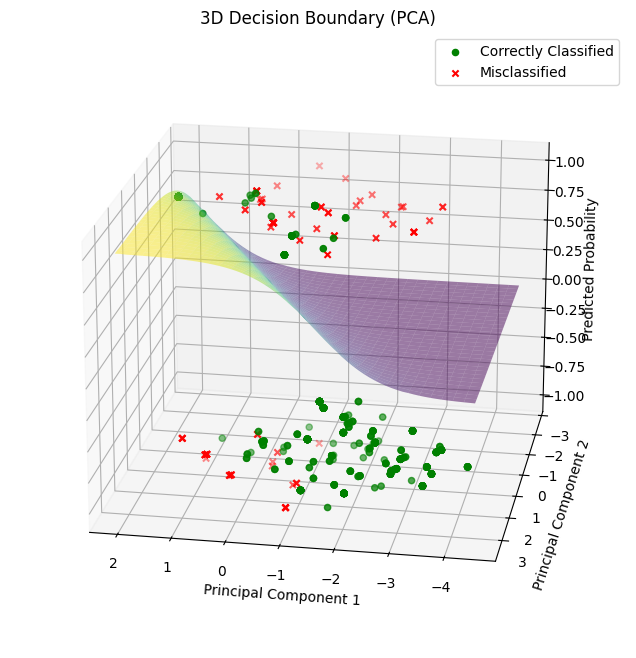

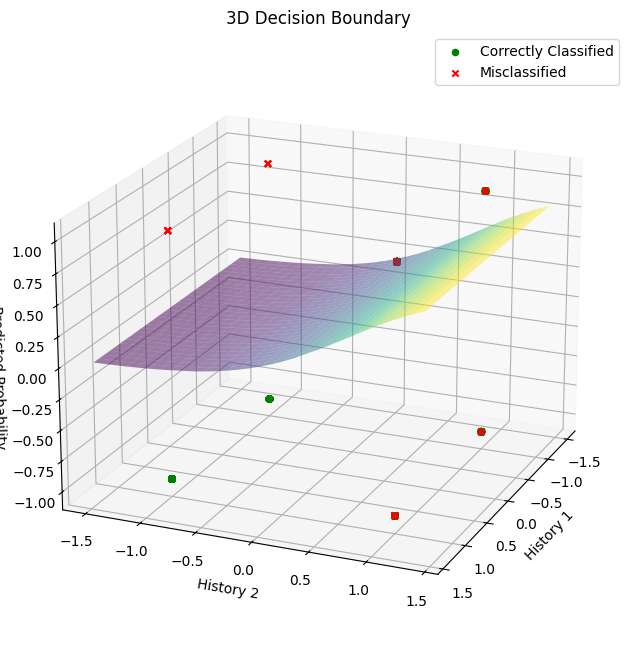

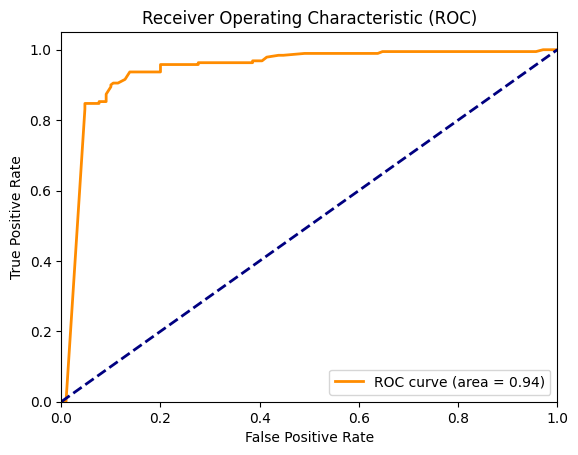

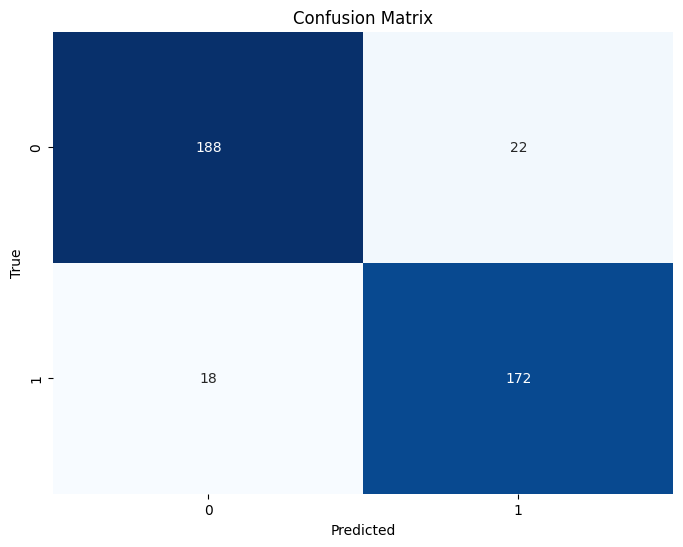

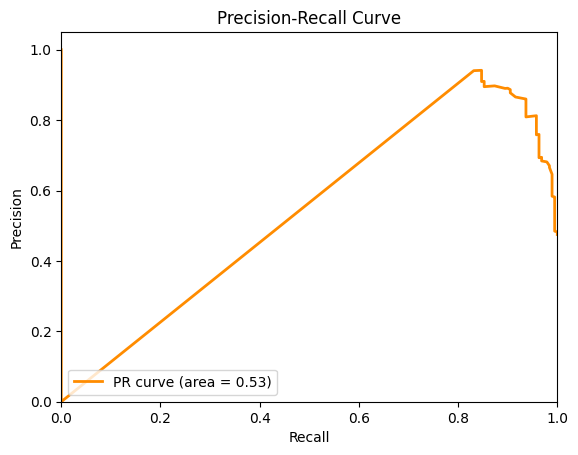

F1-Score: 0.9000400641025641


In [ ]:
plot_decision_boundary_3d_pca(svm_model_sklearn, train_dataset, 20, 100)
plot_decision_boundary_3d_best(train_dataset, svm_model_sklearn, 20, 23)
plot_auroc(svm_model_sklearn, test_dataset)
plot_confusion_matrix(svm_model_sklearn, test_dataset)
plot_precision_recall(svm_model_sklearn, test_dataset)
log_f1_score(svm_model_sklearn, test_dataset)

# Part 3.0: Random Forest

In [ ]:
# Train & test/evaluate functions
def train_random_forest(train_dataset, n_estimators=100, max_depth=None, random_state=None):
    X_train = train_dataset.x_tensor.numpy()
    Y_train = train_dataset.y_tensor.numpy()

    model = RandomForestClassifier(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   random_state=random_state)
    model.fit(X_train, Y_train)
    print(f"estimators: {n_estimators}, max_depth: {max_depth}")
    return model

def evaluate_model(model, dataset, metric='accuracy'):
    X = dataset.x_tensor.numpy()
    Y = dataset.y_tensor.numpy()

    predictions = model.predict(X)
    if metric == 'accuracy':
        score = accuracy_score(Y, predictions)
        print(f"Accuracy: {score:.4f}")
        return score
    elif metric == 'classification_report':
        report = classification_report(Y, predictions)
        print("Classification Report:")
        print(report)
        return report
    else:
        raise ValueError(f"Unsupported metric: {metric}")

# Prediction function
def predict(model, x_values):
    X = x_values.numpy()
    predictions = model.predict(X)
    return torch.tensor(predictions, dtype=torch.float32)


# Part 3.1: Running Random Forest

In [ ]:
file_path = 'balanced_data_3.csv'

X, Y = read_and_preprocess_csv(file_path)
x_values = X_values(X)
y_values = Y_values(Y)
dataset = Dataset(x_values, y_values)

print("x_values-> ", x_values.tensor_form)
print("y_values-> ", y_values.tensor_form)

# Splitting the dataset
train_dataset, val_dataset, test_dataset = split_dataset(dataset, train_rate=0.8, val_rate=0, test_rate=0.2)

# 5-fold cross validation for "number of trees"
folds = five_fold_cross_validation(train_dataset)
tree_values = [5, 10, 50, 100, 200]
results = {}

for n_trees in tree_values:
    accuracies = []

    fold_no = 1
    for train_fold, test_fold in folds:
        # Train Random Forest on the train fold
        rf_model = train_random_forest(train_fold, n_estimators=n_trees)

        # Test the Random Forest on the test fold
        accuracy = evaluate_model(rf_model, test_fold, metric='accuracy')
        accuracies.append(accuracy)
        print(f"Number of trees: {n_trees}, Fold no: {fold_no}, Accuracy: {accuracy:.4f}")
        fold_no += 1

    avg_accuracy = sum(accuracies) / len(accuracies)
    results[n_trees] = avg_accuracy
    print(f"Number of trees: {n_trees}, Average Accuracy: {avg_accuracy:.4f}")

# Find the best number of trees using average accuracy
best_n_trees = max(results, key=results.get)
print(f"Best Number of Trees: {best_n_trees}, Accuracy: {results[best_n_trees]:.4f}")


# Scikit Random Forest Training
print("\nRandom Forest Training")
start_time = time.time()
random_forest_model = train_random_forest(train_dataset, n_estimators=best_n_trees)
train_runtime = time.time() - start_time
print(f"Random Forest Training Runtime: {train_runtime:.4f} seconds")

# Scikit Random Forest Evaluation/Testing
print("\nRandom Forest Evaluation on Test Dataset")
start_time = time.time()
test_accuracy = evaluate_model(random_forest_model, test_dataset, metric='accuracy')
eval_runtime = time.time() - start_time
print(f"Random Forest Evaluation Runtime: {eval_runtime:.4f} seconds")

# Scikit Random Forest Predcition
print("\nRandom Forest Predictions")
start_time = time.time()
predictions = predict(random_forest_model, test_dataset.x_tensor)
pred_runtime = time.time() - start_time
print(f"Random Forest Prediction Runtime: {pred_runtime:.4f} seconds")
print("Predictions:\n", predictions)


x_values->  tensor([[ 1., -1., -1.,  ..., -1.,  1.,  1.],
        [ 1., -1.,  1.,  ..., -1.,  1.,  1.],
        [ 1., -1.,  1.,  ...,  1., -1.,  1.],
        ...,
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.]])
y_values->  tensor([-1., -1., -1.,  ...,  1.,  1.,  1.])
estimators: 5, max_depth: None
Accuracy: 0.9656
Number of trees: 5, Fold no: 1, Accuracy: 0.9656
estimators: 5, max_depth: None
Accuracy: 0.9563
Number of trees: 5, Fold no: 2, Accuracy: 0.9563
estimators: 5, max_depth: None
Accuracy: 0.9125
Number of trees: 5, Fold no: 3, Accuracy: 0.9125
estimators: 5, max_depth: None
Accuracy: 0.9375
Number of trees: 5, Fold no: 4, Accuracy: 0.9375
estimators: 5, max_depth: None
Accuracy: 0.9688
Number of trees: 5, Fold no: 5, Accuracy: 0.9688
Number of trees: 5, Average Accuracy: 0.9481
estimators: 10, max_depth: None
Accuracy: 0.9688
Number of trees: 10, Fold no: 1, Accuracy: 0.9688
estimators: 

# Part 3.2: Plot Random Forest

In [ ]:
plot_decision_boundary_3d_pca(random_forest_model, train_dataset, 20, 200)
plot_decision_boundary_3d_best(train_dataset, random_forest_model, 20, 23)
plot_auroc(random_forest_model, test_dataset)
plot_confusion_matrix(random_forest_model, test_dataset)
plot_precision_recall(random_forest_model, test_dataset)
log_f1_score(random_forest_model, test_dataset)

# Part 4.0: KNN

In [ ]:
def distance_function(vec_x, vec_x_train, distance='euclidean', sigma=1, p=2):
    if distance == 'euclidean':
        # (indeed squared Euclidean distance)
        return torch.sum((vec_x - vec_x_train)**2, dim=1)

    elif distance == 'cosine':
        vec_x_norm = vec_x / torch.norm(vec_x, dim=1, keepdim=True)
        vec_x_train_norm = vec_x_train / torch.norm(vec_x_train, dim=1, keepdim=True)
        cosine_similarity = torch.sum(vec_x_norm * vec_x_train_norm, dim=1)
        return 1 - cosine_similarity # High similarity means lower distance

    elif distance == 'manhattan':
        return torch.sum(torch.abs(vec_x - vec_x_train), dim=1)

    elif distance == 'gaussian':
        if sigma <= 0:
            raise ValueError("Sigma must be greater than 0 for Gaussian distance.")
        euclidean_squared = torch.sum((vec_x - vec_x_train)**2, dim=1)
        return torch.exp(-euclidean_squared / (2 * sigma**2))

    elif distance == 'L_p':
        return torch.sum(torch.abs(vec_x - vec_x_train)**p, dim=1)**(1/p)

    elif distance == 'chebyshev':
        return torch.max(torch.abs(vec_x - vec_x_train), dim=1).values

    else:
        raise ValueError(f"Unsupported distance metric: {distance}")

# Scratch KNN model
def knn(train_dataset, test_dataset, distance='euclidean', K=5):
    x_train, y_train = train_dataset.x_tensor, train_dataset.y_tensor
    x_test, y_test = test_dataset.x_tensor, test_dataset.y_tensor
    y_prediction = []

    # Testing (as no training is required)
    for vec_x in x_test:
        distances = distance_function(vec_x.unsqueeze(0), x_train, distance=distance)
        #print(distances)

        # Indices of the K smallest distances
        k_indices = torch.topk(distances, k=K, largest=False).indices

        # Get the labels of the K nearest neighbors
        k_labels = y_train[k_indices]

        # Perform majority voting (+1 or -1) for prediction
        majority_vote = torch.sign(torch.sum(k_labels))
        y_prediction.append(majority_vote.item())

    # Convert predictions to a tensor
    y_prediction = torch.tensor(y_prediction)

    # Evaluate accuracy
    accuracy = torch.mean((y_prediction == y_test).float())
    print(f"Distance Metric: {distance}, K: {K}, KNN Accuracy: {accuracy.item() * 100:.2f}%")
    return y_prediction

# Part 4.1: Running KNN

In [ ]:
file_path = 'balanced_data_3.csv'

# Preprocessing the dataset
X, Y = read_and_preprocess_csv(file_path)
x_values = X_values(X)
y_values = Y_values(Y)
dataset = Dataset(x_values, y_values)

print("x_values-> ", x_values.tensor_form)
print("y_values-> ", y_values.tensor_form)

# Splitting the dataset
train_dataset, val_dataset, test_dataset = split_dataset(dataset, train_rate=0.8, val_rate=0, test_rate=0.2)

# 5-fold cross validation
k_values = [1, 3, 5, 7, 9]
folds = five_fold_cross_validation(train_dataset)
results = {}

for K in k_values:
    accuracies = []

    fold_no = 1
    for train_fold, test_fold in folds:
        # Test KNN on the test fold with the given K value
        preds = knn(train_fold, test_fold, distance='euclidean', K=K)

        # Calculate accuracy
        accuracy = torch.mean((preds == test_fold.y_tensor).float()).item()
        accuracies.append(accuracy)
        print(f"K: {K}, Fold no: {fold_no}, Accuracy: {accuracy:.4f}")
        fold_no += 1

    avg_accuracy = sum(accuracies) / len(accuracies)
    results[K] = avg_accuracy
    print(f"K: {K}, Average Accuracy: {avg_accuracy:.4f}")

# Find the best K
best_k = max(results, key=results.get)
print(f"Best K: {best_k}, Accuracy: {results[best_k]:.4f}")


# Testing KNN using training dataset
print("\n--- KNN Training and Testing ---")

# Test KNN with K=7 (best_k) and Euclidean distance
start_time = time.time()
predictions_knn = knn(train_dataset, test_dataset, distance='euclidean', K=best_k)
pred_runtime = time.time() - start_time
print(f"KNN Prediction Runtime: {pred_runtime:.4f} seconds")

# Printing predictions
print("\nKNN Predictions:")
print(predictions_knn)


print("\n--- Trying different distance metrics ---")
# Trying out different kernels
metrics = ['euclidean', 'cosine', 'manhattan', 'gaussian', 'L_p', 'chebyshev']

for metric in metrics:
    predictions_knn = knn(train_dataset, test_dataset, distance=metric, K=best_k)



x_values->  tensor([[ 1., -1., -1.,  ..., -1.,  1.,  1.],
        [ 1., -1.,  1.,  ..., -1.,  1.,  1.],
        [ 1., -1.,  1.,  ...,  1., -1.,  1.],
        ...,
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  ...,  1.,  1.,  1.]])
y_values->  tensor([-1., -1., -1.,  ...,  1.,  1.,  1.])
Distance Metric: euclidean, K: 1, KNN Accuracy: 96.25%
K: 1, Fold no: 1, Accuracy: 0.9625
Distance Metric: euclidean, K: 1, KNN Accuracy: 94.69%
K: 1, Fold no: 2, Accuracy: 0.9469
Distance Metric: euclidean, K: 1, KNN Accuracy: 90.31%
K: 1, Fold no: 3, Accuracy: 0.9031
Distance Metric: euclidean, K: 1, KNN Accuracy: 92.81%
K: 1, Fold no: 4, Accuracy: 0.9281
Distance Metric: euclidean, K: 1, KNN Accuracy: 95.63%
K: 1, Fold no: 5, Accuracy: 0.9563
K: 1, Average Accuracy: 0.9394
Distance Metric: euclidean, K: 3, KNN Accuracy: 96.88%
K: 3, Fold no: 1, Accuracy: 0.9688
Distance Metric: euclidean, K: 3, KNN Accuracy: 95.31%
K: 3, Fold no: 